In [9]:
import os
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import json
import requests
from model import load_model
import numpy as np

In [10]:

def return_image(index:int, dir:str):
    """ returns image in the given index from the directory"""
    image_extensions = ['JPEG', 'png', 'gif', 'bmp', 'tiff', 'webp']
    images = []

    for root, _, files in os.walk(dir):
        for file in files:
            file_path = os.path.join(root, file)
            images.append(file_path)
    if index < 0 or index >= len(images):
        raise IndexError(f"Index {index} is out of range. Available images: {len(images)}")
    image_path = images[index]
    img = Image.open(image_path)
    return img, image_path

In [11]:
def preprocess_image(image: Image):
    """Preprocesses the image to be used by the model."""
    transform = transforms.Compose([
        transforms.Resize(256),  # Resize the shorter side to 256
        transforms.CenterCrop(224),  # Crop the center to 224x224
        transforms.ToTensor(),  # Convert the image to tensor
        transforms.Normalize(  # Normalize using ImageNet mean and std
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    image_tensor = transform(image)
    return image_tensor

In [12]:
def load_class_labels():
    """Loads the ImageNet class labels."""
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
    response = requests.get(url)
    return response.json()

In [13]:
def predict_class(model, image_tensor):
    """Predicts the class using the trained model."""
    outputs = model(image_tensor.unsqueeze(0))
    preds = outputs.argmax(dim=1)
    return preds.item()

In [14]:
def print_image(image, index, path):
    """Displays the image after preprocessing."""
    # Preprocess the image
    image_tensor = preprocess_image(image)

    # Convert tensor to numpy array and denormalize the image for display
    image_numpy = image_tensor.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_numpy = std * image_numpy + mean  # Denormalize
    image_numpy = np.clip(image_numpy, 0, 1)  # Ensure values are between 0 and 1

    # Display the image
    plt.imshow(image_numpy)
    plt.title(f"Image at {index}: {os.path.basename(path)}")
    plt.axis('off')
    plt.show()

In [15]:
def image_prediction(index: int, dir: str):
    """Main function to load an image, predict its class, and display it."""
    # Load the model
    model = load_model()

    # Load the image
    image, image_path = return_image(index, dir)

    # Preprocess the image
    image_tensor = preprocess_image(image)

    # Predict the class
    predicted_class_idx = predict_class(model, image_tensor)

    # Load class labels
    class_idx = load_class_labels()
    predicted_class_label = class_idx[str(predicted_class_idx)][1]

    # Print the results
    print_image(image, index, image_path)
    print(f"Predicted Class Index: {predicted_class_idx}")
    print(f"Predicted Class Label: {predicted_class_label}")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


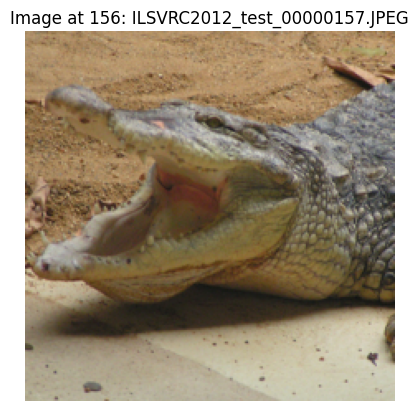

Predicted Class Index: 49
Predicted Class Label: African_crocodile


In [16]:
dir = r"/teamspace/studios/this_studio/xai-fgsm/src/data/imagenet/"
index = 156
image_prediction(index, dir)

In [17]:
def fgsm_attack(model, images, labels, epsilon):
    """
    Perform the FGSM attack on the given images.

    Parameters:
        model (torch.nn.Module): The trained model.
        images (torch.Tensor): The input images.
        labels (torch.Tensor): The true labels for the input images.
        epsilon (float): The perturbation magnitude for the attack.

    Returns:
        torch.Tensor: The adversarially perturbed images.
    """
    # Ensure images require gradients
    images.requires_grad = True

    # Forward pass to get model outputs
    outputs = model(images)

    # Calculate the loss
    loss = torch.nn.CrossEntropyLoss()(outputs, labels)

    # Zero the gradients and compute the gradients of the loss w.r.t. images
    model.zero_grad()
    loss.backward()

    # Create the adversarial images by adding the perturbation
    perturbed_images = images + epsilon * images.grad.sign()

    # Return the perturbed images clipped to valid image range [0, 1]
    return torch.clamp(perturbed_images, 0, 1)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


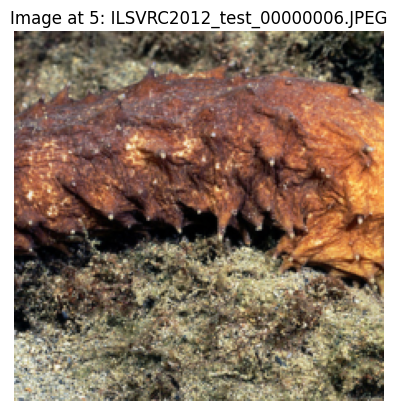

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [26]:
def image_prediction(index: int, dir: str, epsilon: float = 0.1):
    """Main function to load an image, perform FGSM attack, predict its class, and display it."""
    # Load the model
    model = load_model()

    # Load the image
    image, image_path = return_image(index, dir)
    
    # Preprocess the image
    image_tensor = preprocess_image(image)
    label = model(image_tensor.unsqueeze(0))
    # Perform FGSM attack
    adversarial_image = fgsm_attack(model, image_tensor.unsqueeze(0), label, epsilon)

    # Predict the class for original image
    predicted_class_idx = predict_class(model, image_tensor)

    # Load class labels
    class_idx = load_class_labels()
    predicted_class_label = class_idx[str(predicted_class_idx)][1]

    # Predict the class for adversarial image
    adversarial_image = adversarial_image.squeeze(0)
    adversarial_class_idx = predict_class(model, adversarial_image)

    # Get label for adversarial image
    adversarial_class_label = class_idx[str(adversarial_class_idx)][1]

    # Print the results
    print_image(image, index, image_path)
    print_image(adversarial_image, index, image_path)
    print(f"Original Image Class Index: {predicted_class_idx}")
    print(f"Original Image Class Label: {predicted_class_label}")
    print(f"Adversarial Image Class Index: {adversarial_class_idx}")
    print(f"Adversarial Image Class Label: {adversarial_class_label}")

# Call the function with an index and directory path
dir = r"/teamspace/studios/this_studio/xai-fgsm/src/data/imagenet/"
index = 5
image_prediction(index, dir, epsilon=0.1)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


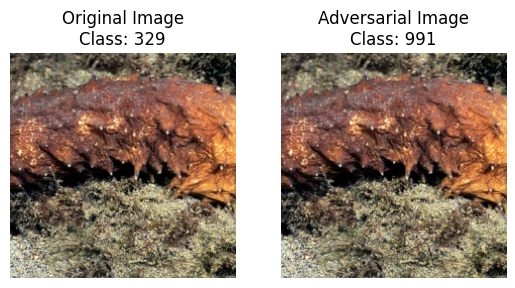

In [33]:
import torch.nn.functional as F  # Add this import

# Load and preprocess the image
model = load_model()
image_path = "/teamspace/studios/this_studio/xai-fgsm/src/data/imagenet/ILSVRC2012_test_00000006.JPEG"  # Replace with your image path
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the shorter side to 256
    transforms.CenterCrop(224),  # Crop the center to 224x224
    transforms.ToTensor(),  # Convert the image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Predict the class of the original image
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class_idx = torch.max(output, 1)
original_class_idx = predicted_class_idx.item()

# Display the original image and its predicted class
image_numpy = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_numpy = std * image_numpy + mean  # Denormalize
image_numpy = np.clip(image_numpy, 0, 1)  # Ensure values are between 0 and 1

plt.subplot(1, 2, 1)
plt.imshow(image_numpy)
plt.title(f"Original Image\nClass: {original_class_idx}")
plt.axis('off')

# Perform FGSM attack
epsilon = 0.01
image_tensor.requires_grad = True
output = model(image_tensor)
loss = F.cross_entropy(output, torch.tensor([original_class_idx]))
model.zero_grad()
loss.backward()
data_grad = image_tensor.grad.data
perturbed_image = image_tensor + epsilon * data_grad.sign()
#perturbed_image = torch.clamp(perturbed_image, 0, 1)

# Predict the class of the adversarial image
with torch.no_grad():
    output = model(perturbed_image)
    _, predicted_class_idx = torch.max(output, 1)
adversarial_class_idx = predicted_class_idx.item()

# Display the adversarial image and its predicted class
adversarial_image_numpy = perturbed_image.detach().squeeze(0).permute(1, 2, 0).cpu().numpy()
adversarial_image_numpy = std * adversarial_image_numpy + mean  # Denormalize
adversarial_image_numpy = np.clip(adversarial_image_numpy, 0, 1)

plt.subplot(1, 2, 2)
plt.imshow(adversarial_image_numpy)
plt.title(f"Adversarial Image\nClass: {adversarial_class_idx}")
plt.axis('off')

plt.show()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


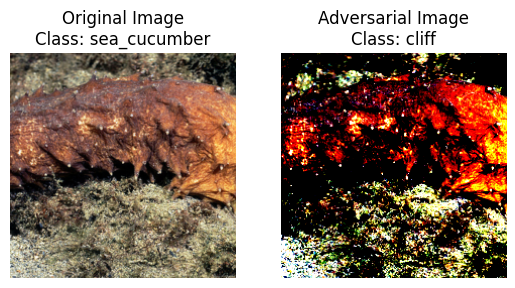

Original Image Class Index: 329
Original Image Class Label: sea_cucumber
Adversarial Image Class Index: 972
Adversarial Image Class Label: cliff
/teamspace/studios/this_studio/xai-fgsm/src/data/imagenet/ILSVRC2012_test_00000006.JPEG


In [32]:
def image_prediction(index: int, dir: str, epsilon: float = 0.01):
    """Main function to load an image, perform FGSM attack, predict its class, and display it."""
    # Load the model
    model = load_model()  # This should be your model loading function

    # Load the image (replace with your own image loading function)
    image, image_path = return_image(index, dir)  # Replace with your image loading logic
    
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize(256),  # Resize the shorter side to 256
        transforms.CenterCrop(224),  # Crop the center to 224x224
        transforms.ToTensor(),  # Convert the image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Predict the class of the original image
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class_idx = torch.max(output, 1)
    original_class_idx = predicted_class_idx.item()

    # Load class labels (replace with your label loading logic)
    class_idx = load_class_labels()  # Replace with your class label loading function
    predicted_class_label = class_idx[str(original_class_idx)][1]

    # Display the original image and its predicted class
    image_numpy = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_numpy = std * image_numpy + mean  # Denormalize
    image_numpy = np.clip(image_numpy, 0, 1)  # Ensure values are between 0 and 1

    plt.subplot(1, 2, 1)
    plt.imshow(image_numpy)
    plt.title(f"Original Image\nClass: {predicted_class_label}")
    plt.axis('off')

    # Perform FGSM attack
    image_tensor.requires_grad = True
    output = model(image_tensor)
    loss = F.cross_entropy(output, torch.tensor([original_class_idx]))
    model.zero_grad()
    loss.backward()
    data_grad = image_tensor.grad.data
    perturbed_image = image_tensor + epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # Ensure perturbed image is within valid range

    # Predict the class of the adversarial image
    with torch.no_grad():
        output = model(perturbed_image)
        _, predicted_class_idx = torch.max(output, 1)
    adversarial_class_idx = predicted_class_idx.item()

    # Get label for adversarial image
    adversarial_class_label = class_idx[str(adversarial_class_idx)][1]

    # Display the adversarial image and its predicted class
    adversarial_image_numpy = perturbed_image.detach().squeeze(0).permute(1, 2, 0).cpu().numpy()
    #adversarial_image_numpy = std * adversarial_image_numpy + mean  # Denormalize
    #adversarial_image_numpy = np.clip(adversarial_image_numpy, 0, 1)

    plt.subplot(1, 2, 2)
    plt.imshow(adversarial_image_numpy)
    plt.title(f"Adversarial Image\nClass: {adversarial_class_label}")
    plt.axis('off')

    # Show the images
    plt.show()

    # Print the results
    print(f"Original Image Class Index: {original_class_idx}")
    print(f"Original Image Class Label: {predicted_class_label}")
    print(f"Adversarial Image Class Index: {adversarial_class_idx}")
    print(f"Adversarial Image Class Label: {adversarial_class_label}")
    print(image_path)

# Call the function with an index and directory path
dir = r"/teamspace/studios/this_studio/xai-fgsm/src/data/imagenet/"
index = 5
image_prediction(index, dir, epsilon=0.1)